## Cargar Datos

In [ ]:
# SE DESCARGA EN CARPETA EN LA QUE ESTÁ ESTE NOTEBOOK
#!git clone "https://github.com/cienciadatos/niche_fraudsters.git"

# SOLO NECESITAMOS ESTOS DATASETS
#!unzip "niche_fraudsters/df_fin.zip"

## 1. Importar Librerías

In [1]:
# Importar todas las funciones y librerías - No cambiar esta celda.
# ==============================================================================
from data_models import *

## 2. Generar Datos de Train

In [2]:
# GENERAR LAS CONSTANTES DE LOS DATOS
# ==============================================================================
DF_FINAL_TRAIN = "df_final_train.csv"
DF_FINAL_TEST  = "df_final_test.csv"

In [29]:
X_train, X_test, y_train, y_test = prepare_train(DF_FINAL_TRAIN, 0.7)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

## 3. Entrenamiento y Evaluación

### Modelo 1. Random Forest

In [5]:
# Librerías necesarias para ejecutar tu modelo
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# GRIDSEARCH Y CROSS-VALIDATION
# ==============================================================================
param_grid_RF = {'n_estimators': [1,3,5,10],
              'max_features': [1, 5, 7, 'sqrt'],
              'max_depth'   : [None, 3],
              'criterion'   : ['entropy']
             }

grid_RF = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid_RF,
        scoring    = 'average_precision',
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_RF.fit(X = X_train, y = y_train)

In [6]:
# RESULTADOS DEL GRIDSEARCH
# ==============================================================================
resultados_RF = pd.DataFrame(grid_RF.cv_results_)
resultados_RF.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

# MEJORES HIPERPARÁMETROS
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_RF.best_params_, ":", grid_RF.best_score_, grid_RF.scoring)
#modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'n_estimators': 10} : 0.15681538722484673 average_precision


In [13]:
# MEJORES HIPERPARÁMETROS DEL MODELO
# ==============================================================================
n_estimators = 10
max_features = 7
criterion = 'entropy'
max_depth = None

In [14]:
# CONSTRICCIÓN DEL MODELO
# ==============================================================================
rf = RandomForestClassifier(
          n_estimators = n_estimators,
          max_features = max_features,
          criterion    = criterion,
          max_depth    = max_depth,
          random_state = 123
        )

In [15]:
# ENTRENAMIENTO DEL MODELO
# ==============================================================================
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=7, n_estimators=10,
                       random_state=123)

In [16]:
# PREDICCIÓN ETIQUETAS
# ==============================================================================
y_pred = rf.predict(X_test)

# PREDICCIÓN PROBABILIDADES
# ==============================================================================
y_pred_prob = rf.predict_proba(X_test)
prob_pos = y_pred_prob[:, 1] # probabilidades de la clase positiva (FRAUDE)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27420
           1       0.37      0.09      0.14       418

    accuracy                           0.98     27838
   macro avg       0.68      0.54      0.57     27838
weighted avg       0.98      0.98      0.98     27838



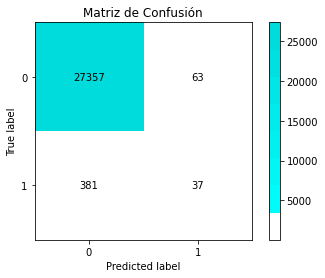

RANDOM_FOREST 1.0
               param     value
0             PR AUC  0.136378
1           F1 Micro  0.984051
2  Balanced Accuracy  0.543110


In [17]:
# MÉTRICAS DEL MODELO
# ==============================================================================
print_metrics(y_test, y_pred)
print_conf_matrix(y_test, y_pred)
data_metrics = pr_auc_score(y_test, prob_pos, y_pred, X_test, "Random_Forest", "1.0")

### Modelo 2. XGBoost

In [11]:
# Librerías necesarias para ejecutar tu modelo
# ==============================================================================
import xgboost as xgb

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid_XGB = {'n_estimators': [10,15,20,30],
              'max_depth'   : [20, 50, 100],
              'eta'         : [0.1,0.4,0.5],
              'tree_method' : ['exact','approx'],
              'booster'     : ['gbtree','gblinear']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
xgb_grid = GridSearchCV(
            estimator  = xgb.XGBClassifier(random_state = 123),
            param_grid = param_grid_XGB,
            scoring    = 'average_precision',
            cv         = RepeatedKFold(n_splits=4, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

xgb_grid.fit(X = X_train, y = y_train)

In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(xgb_grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(xgb_grid.best_params_, ":", xgb_grid.best_score_, xgb_grid.scoring)
#modelo_final = grid.best_estimator_

In [30]:
# Parámetros del Modelo
# ==============================================================================
n_estimators = 15
booster = "gbtree"
tree_method = 'exact'
max_depth = 50
eta = 0.37100
objective = "binary:logistic" 
nthread = 2
eval_metric = average_precision_score

In [31]:
# Construcción del Modelo
# ==============================================================================
xgb_model = xgb.XGBClassifier(
                n_estimators = n_estimators,
                objective = objective,
                booster = booster,
                max_depth = max_depth,
                eta = eta,
                tree_method = tree_method,
                nthread = nthread,
                random_state=42,
                eval_metric = eval_metric,
                scale_pos_weight = 1.4
)

In [32]:
# Entrenamiento del Modelo
# ==============================================================================
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.371,
              eval_metric=<function average_precision_score at 0x16b46aca0>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=15, n_jobs=None,
              nthread=2, num_parallel_tree=None, ...)

In [33]:
# Predicción
# ==============================================================================
y_pred = xgb_model.predict(X_test)

In [34]:
# PREDICCIÓN ETIQUETAS
# ==============================================================================
y_pred = xgb_model.predict(X_test)

# PREDICCIÓN PROBABILIDADES
# ==============================================================================
y_pred_prob = xgb_model.predict_proba(X_test)
prob_pos = y_pred_prob[:, 1] # probabilidades de la clase positiva (FRAUDE)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27420
           1       0.39      0.08      0.13       418

    accuracy                           0.98     27838
   macro avg       0.69      0.54      0.56     27838
weighted avg       0.98      0.98      0.98     27838



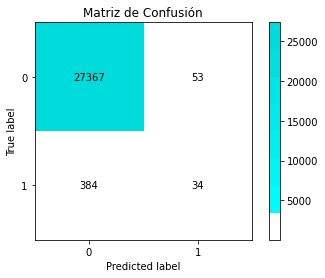

XGBOOST 1.0
               param     value
0             PR AUC  0.145971
1           F1 Micro  0.984302
2  Balanced Accuracy  0.539703


In [35]:
# MÉTRICAS DEL MODELO
# ==============================================================================
print_metrics(y_test, y_pred)
print_conf_matrix(y_test, y_pred)
data_metrics = pr_auc_score(y_test, prob_pos, y_pred, X_test, "XGBoost", "1.0")

### Modelo 3. XGBoost Agnóstico

In [11]:
# Librerías necesarias para ejecutar tu modelo
# ==============================================================================
import xgboost as xgb

In [37]:
X_train = X_train.drop(['apple_prod','computers_prod',
              'warranty_prod','fulfilment_prod'],axis=1)
X_test = X_test.drop(['apple_prod','computers_prod',
              'warranty_prod','fulfilment_prod'],axis=1)

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid_XGB_agn = {'n_estimators': [10,15,20,30],
                      'max_depth'   : [20, 50, 100],
                      'eta'         : [0.1,0.4,0.5],
                      'tree_method' : ['exact','approx'],
                      'booster'     : ['gbtree','gblinear']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
xgb_grid_agn = GridSearchCV(
            estimator  = xgb.XGBClassifier(random_state = 123),
            param_grid = param_grid_XGB_agn,
            scoring    = 'average_precision',
            cv         = RepeatedKFold(n_splits=4, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

xgb_grid_agn.fit(X = X_train, y = y_train)

In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(xgb_grid_agn.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(xgb_grid_agn.best_params_, ":", xgb_grid_agn.best_score_, xgb_grid_agn.scoring)
#modelo_final = grid.best_estimator_

In [41]:
# Parámetros del Modelo
# ==============================================================================
n_estimators = 20
booster = "gbtree"
tree_method = 'exact'
max_depth = 20
eta = 0.4
objective = "binary:logistic" 
nthread = 2
eval_metric = average_precision_score

In [42]:
# Construcción del Modelo
# ==============================================================================
xgb_agn = xgb.XGBClassifier(
            n_estimators = n_estimators,
            objective = objective,
            booster = booster,
            max_depth = max_depth,
            eta = eta,
            tree_method = tree_method,
            nthread = nthread,
            random_state=42,
            eval_metric = eval_metric,
            scale_pos_weight = 1.4
)

In [43]:
# Entrenamiento del Modelo
# ==============================================================================
xgb_agn.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4,
              eval_metric=<function average_precision_score at 0x16b46aca0>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              nthread=2, num_parallel_tree=None, ...)

In [44]:
# Predicción
# ==============================================================================
y_pred = xgb_agn.predict(X_test)

In [45]:
# PREDICCIÓN ETIQUETAS
# ==============================================================================
y_pred = xgb_agn.predict(X_test)

# PREDICCIÓN PROBABILIDADES
# ==============================================================================
y_pred_prob = xgb_agn.predict_proba(X_test)
prob_pos = y_pred_prob[:, 1] # probabilidades de la clase positiva (FRAUDE)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27420
           1       0.39      0.08      0.13       418

    accuracy                           0.98     27838
   macro avg       0.69      0.54      0.56     27838
weighted avg       0.98      0.98      0.98     27838



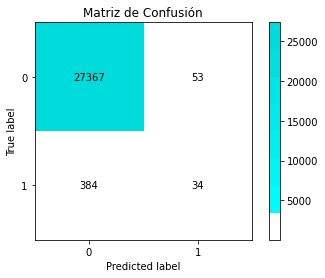

XGBOOST Agnóstico
               param     value
0             PR AUC  0.143241
1           F1 Micro  0.984302
2  Balanced Accuracy  0.539703


In [46]:
# MÉTRICAS DEL MODELO
# ==============================================================================
print_metrics(y_test, y_pred)
print_conf_matrix(y_test, y_pred)
data_metrics = pr_auc_score(y_test, prob_pos, y_pred, X_test, "XGBoost", "Agnóstico")

## 4. Etiquetado para el Challenge

### Modelo 1. Random Forest 

In [47]:
X_train, X_test, y_train = prepare_test(DF_FINAL_TRAIN, DF_FINAL_TEST)

In [48]:
# HIPERPARÁMETROS DEL MODELO
# ==============================================================================
n_estimators = 10
max_features = 7
criterion = 'entropy'
max_depth = None

In [49]:
# Construcción del Modelo
# ==============================================================================
rf = RandomForestClassifier(
          n_estimators = n_estimators,
          max_features = max_features,
          criterion    = criterion,
          max_depth    = max_depth,
          random_state = 123
        )

In [50]:
# Entrena de nuevo el modelo (ahora se usa el 100% de la data de Train)
# ==============================================================================
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=7, n_estimators=10,
                       random_state=123)

In [51]:
# Predicción de Etiquetas y de las probabilidades del Modelo
# ==============================================================================
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)

In [52]:
# GENERAR EL OUTPUT DEL MODELO
# ==============================================================================
generate_output(y_pred_prob, X_test, 'Random_Forest_Final')

   index     ID  fraud_flag
0      0  64707    0.000000
1      1  63919    0.000000
2      2  15664    0.000000
3      3   6626    0.082572
4      4  26766    0.068885


### Modelo 2. XGBoost

In [53]:
# HIPERPARÁMETROS DEL MODELO
# ==============================================================================
n_estimators = 15
booster = "gbtree"
tree_method = 'exact'
max_depth = 50
eta = 0.37100
objective = "binary:logistic" 
nthread = 2
eval_metric = average_precision_score

In [54]:
# Construcción del Modelo
# ==============================================================================
xgb_model = xgb.XGBClassifier(
                n_estimators = n_estimators,
                objective = objective,
                booster = booster,
                max_depth = max_depth,
                eta = eta,
                tree_method = tree_method,
                nthread = nthread,
                random_state=42,
                eval_metric = eval_metric,
                scale_pos_weight = 1.4
)

In [55]:
# Entrena de nuevo el modelo (ahora se usa el 100% de la data de Train)
# ==============================================================================
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.371,
              eval_metric=<function average_precision_score at 0x16b46aca0>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=50,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=15, n_jobs=None,
              nthread=2, num_parallel_tree=None, ...)

In [56]:
# Predicción de Etiquetas y de las probabilidades del Modelo
# ==============================================================================
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)

In [57]:
# GENERAR EL OUTPUT DEL MODELO
# ==============================================================================
generate_output(y_pred_prob, X_test, 'XGBoost_Final')

   index     ID  fraud_flag
0      0  64707    0.001799
1      1  63919    0.002842
2      2  15664    0.003055
3      3   6626    0.037762
4      4  26766    0.090818


### Modelo 3. XGBoost Agnóstico

In [58]:
X_train = X_train.drop(['apple_prod','computers_prod',
              'warranty_prod','fulfilment_prod'],axis=1)
X_test = X_test.drop(['apple_prod','computers_prod',
              'warranty_prod','fulfilment_prod'],axis=1)

In [59]:
# HIPERPARÁMETROS DEL MODELO
# ==============================================================================
n_estimators = 20
booster = "gbtree"
tree_method = 'exact'
max_depth = 20
eta = 0.4
objective = "binary:logistic" 
nthread = 2
eval_metric = average_precision_score

In [60]:
# Construcción del Modelo
# ==============================================================================
xgb_agn = xgb.XGBClassifier(
                n_estimators = n_estimators,
                objective = objective,
                booster = booster,
                max_depth = max_depth,
                eta = eta,
                tree_method = tree_method,
                nthread = nthread,
                random_state=42,
                eval_metric = eval_metric,
                scale_pos_weight = 1.4
)

In [61]:
# Entrena de nuevo el modelo (ahora se usa el 100% de la data de Train)
# ==============================================================================
xgb_agn.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4,
              eval_metric=<function average_precision_score at 0x16b46aca0>,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              nthread=2, num_parallel_tree=None, ...)

In [62]:
# Predicción de Etiquetas y de las probabilidades del Modelo
# ==============================================================================
y_pred = xgb_agn.predict(X_test)
y_pred_prob = xgb_agn.predict_proba(X_test)

In [63]:
# GENERAR EL OUTPUT DEL MODELO
# ==============================================================================
generate_output(y_pred_prob, X_test, 'XGBoost_Agnóstico_Final')

   index     ID  fraud_flag
0      0  64707    0.000198
1      1  63919    0.001011
2      2  15664    0.002015
3      3   6626    0.052892
4      4  26766    0.076111
